In [1]:
import numpy as np
import pandas as pd
import os, time, pickle, gzip

from sklearn import preprocessing as pp

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

In [2]:
# Load the datasets
from pathlib import Path

DATA_FILE = Path("./data/mnist_data") / "mnist.pkl.gz"

f = gzip.open(DATA_FILE, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [3]:
# Verify shape of datasets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [4]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train), \
                         len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [5]:
# Describe the training matrix
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022784,0.015424,0.012080,0.007218,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992188,0.992188,0.988281,0.988281,0.992188,0.242188,0.0,0.0,0.0,0.0


In [6]:
# Show the labels
y_train.head()

0    5
1    0
2    4
3    1
4    9
dtype: int64

In [7]:
def view_digit(example):
    label = y_train.loc[example]
    image = X_train.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

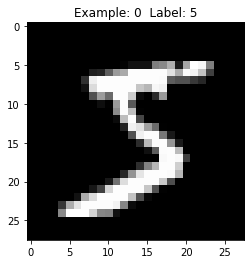

In [8]:
# View the first digit
view_digit(0)

In [9]:
def one_hot(series):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(series)+1))
    return label_binarizer.transform(series)

In [10]:
def reverse_one_hot(originalSeries, newSeries):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(originalSeries)+1))
    return label_binarizer.inverse_transform(newSeries)

In [11]:
# Create one-hot vectors for the labels
y_train_oneHot = one_hot(y_train)
y_validation_oneHot = one_hot(y_validation)
y_test_oneHot = one_hot(y_test)

In [12]:
# Show one-hot vector for example 0, which is the number 5
y_train_oneHot[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [13]:
# Principal Component Analysis
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [14]:
# Percentage of Variance Captured by 784 principal components
print("Variance Explained by all 784 principal components: ", \
      sum(pca.explained_variance_ratio_))

Variance Explained by all 784 principal components:  0.9999999839005775


In [15]:
# Percentage of Variance Captured by X principal components
importanceOfPrincipalComponents = \
    pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('Variance Captured by First 10 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:49].sum(axis=1).values)
print('Variance Captured by First 100 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:99].sum(axis=1).values)
print('Variance Captured by First 200 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:199].sum(axis=1).values)
print('Variance Captured by First 300 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:299].sum(axis=1).values)

Variance Captured by First 10 Principal Components:  [0.4887615]
Variance Captured by First 20 Principal Components:  [0.6439795]
Variance Captured by First 50 Principal Components:  [0.8248605]
Variance Captured by First 100 Principal Components:  [0.91465837]
Variance Captured by First 200 Principal Components:  [0.9665007]
Variance Captured by First 300 Principal Components:  [0.9862489]


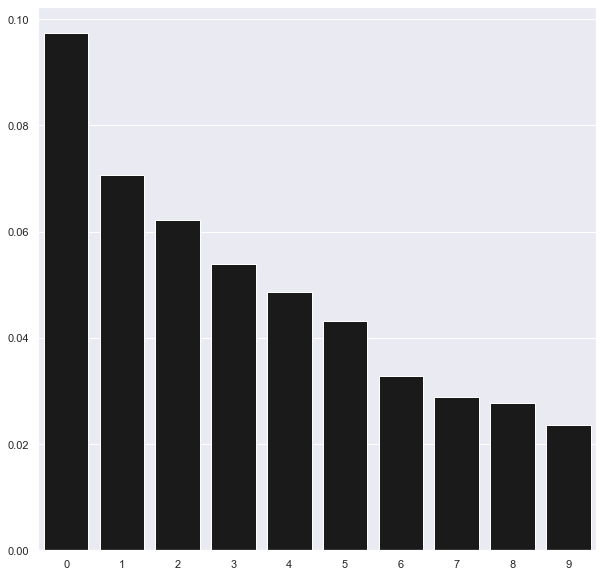

In [16]:
sns.set(rc={'figure.figsize':(10,10)})
sns.barplot(data=importanceOfPrincipalComponents.loc[:,0:9],color='k')
plt.show()

In [17]:
def scatter_plot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

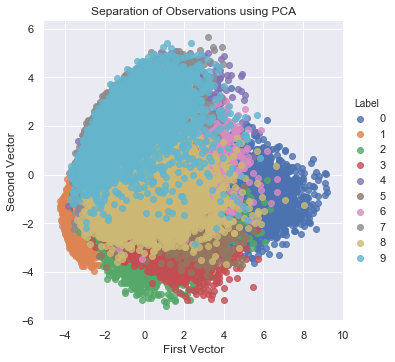

In [18]:
scatter_plot(X_train_PCA, y_train, "PCA")

Text(0.5, 1, 'Separation of Observations Using Original Feature Set')

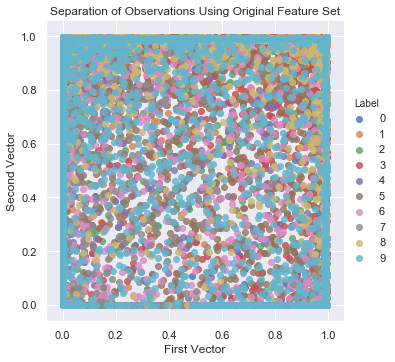

In [19]:
X_train_scatter = pd.DataFrame(data=X_train.loc[:,[350,406]], index=X_train.index)
X_train_scatter = pd.concat((X_train_scatter,y_train), axis=1, join="inner")
X_train_scatter.columns = ["First Vector", "Second Vector", "Label"]
sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=X_train_scatter, fit_reg=False)
ax = plt.gca()
ax.set_title("Separation of Observations Using Original Feature Set")

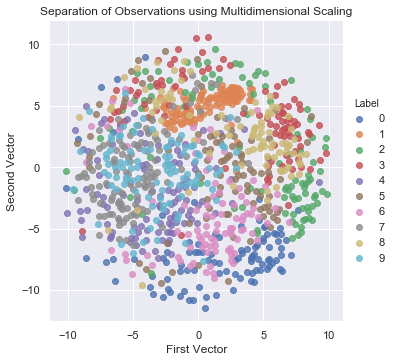

In [20]:
# Multidimensional Scaling
from sklearn.manifold import MDS

n_components = 2
n_init = 12
max_iter = 1200
metric = True
n_jobs = 4
random_state = 2018

mds = MDS(n_components=n_components, n_init=n_init, max_iter=max_iter, \
          metric=metric, n_jobs=n_jobs, random_state=random_state)

X_train_mds = mds.fit_transform(X_train.loc[0:1000,:])
X_train_mds = pd.DataFrame(data=X_train_mds, index=train_index[0:1001])

scatter_plot(X_train_mds, y_train, "Multidimensional Scaling")

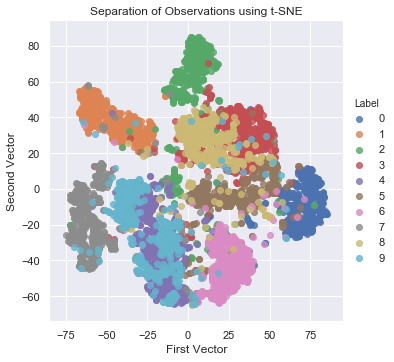

In [22]:
# t-SNE
from sklearn.manifold import TSNE

n_components = 2
learning_rate = 300
perplexity = 30
early_exaggeration = 12
init = 'random'
random_state = 2018

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate, \
            perplexity=perplexity, early_exaggeration=early_exaggeration, \
            init=init, random_state=random_state)

X_train_tSNE = tSNE.fit_transform(X_train_PCA.loc[:5000,:9])
X_train_tSNE = pd.DataFrame(data=X_train_tSNE, index=train_index[:5001])

scatter_plot(X_train_tSNE, y_train, "t-SNE")